In [1]:
from profiler.core import *

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_graph(graph, label=False, directed=False, circle=False):
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    for e in graph.get_edges():
        if label:
            G.add_edge(graph.idx_to_name[e[0]], graph.idx_to_name[e[1]])
        else:
            G.add_edge(e[0], e[1])
    if circle:
        nx.draw(G, with_labels=True, pos=nx.circular_layout(G))
    else:
        nx.draw(G, with_labels=True)
    plt.draw()
    return G
def print_tree(T, node, level=0):
    print("{}[{}]{}".format("--"*level, node, T.idx_to_name[node]))
    for c in T.get_children(node):
        print_tree(T, c, level+1)

In [3]:
pf = Profiler(workers=2, verbose=False, tol=0.01)

In [4]:
pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
#pf.session.load_data(name='hospital', src='file', fpath='data/hospital.csv', embedtxt=False)

INFO:profiler.utility:[0.9691591262817383] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "airlineid": "text",
    "sairportid": "text",
    "dairportid": "text",
    "codeshare": "categorical",
    "eq1": "categorical",
    "eq2": "categorical",
    "eq3": "categorical",
    "eq4": "categorical",
    "eq5": "categorical",
    "eq8": "categorical",
    "eq12": "categorical",
    "eq14": "categorical",
    "eq15": "categorical",
    "eq17": "categorical",
    "eq19": "categorical",
    "eq20": "categorical",
    "eq22": "categorical",
    "eq25": "categorical",
    "eq28": "categorical",
    "eq30": "categorical",
    "eq31": "categorical",
    "eq45": "categorical",
    "eq46": "categorical",
    "eq71": "categorical",
    "name1": "numeric",
    "name2": "categorical",
    "name4": "categorical",
    "acountry": "text",
    "active": "categorical",
    "scity": "text",
    "scountry": "text",
    "slatitude": "numeric",
    "slongitude": "numeric",
    "sti

In [5]:
# pf.session.ds.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State'], 
#                          ['categorical', 'numeric', 'categorical', 'text'])

In [6]:
# TODO save embedding vectors
# pf.session.load_embedding()

In [7]:
pf.session.load_training_data()
pf.session.learn_structure()


INFO:profiler.utility:[7.310988187789917] Create Training Data start

INFO:profiler.utility:[22.573662996292114] Create Training Data execution time: 15.262674808502197

INFO:profiler.utility:[22.574697971343994] Recover Moral Graph start

/Users/zhihan/anaconda3/envs/fd3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 300 iteration: dual gap: 1.111e-03
  % (max_iter, d_gap), ConvergenceWarning)
INFO:profiler.utility:[28.068791151046753] Recover Moral Graph execution time: 5.494093179702759



In [8]:
s = pf.session.struct_engine
inv_cov = s.inv_cov

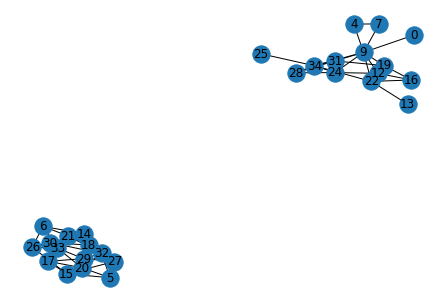

In [9]:
dg = s.construct_moral_graphs(s.inv_cov)
plot_graph(dg)

In [10]:
gs = dg.get_undirected_connected_components()

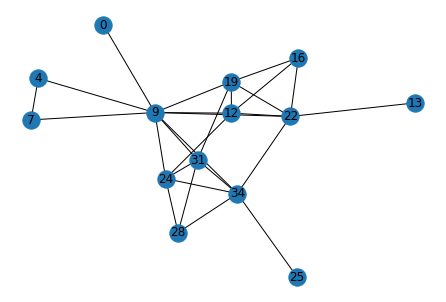

In [11]:
G = gs[0]
netg = plot_graph(G)

In [12]:
from profiler.graph import *
TD = treewidth_decomp(G)

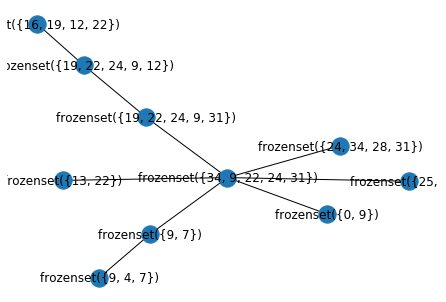

In [13]:
plot_graph(TD, label=True)

In [14]:
TD.idx_to_name

{0: frozenset({9, 22, 24, 31, 34}),
 1: frozenset({9, 19, 22, 24, 31}),
 2: frozenset({9, 12, 19, 22, 24}),
 3: frozenset({24, 28, 31, 34}),
 4: frozenset({12, 16, 19, 22}),
 5: frozenset({7, 9}),
 6: frozenset({4, 7, 9}),
 7: frozenset({25, 34}),
 8: frozenset({13, 22}),
 9: frozenset({0, 9})}

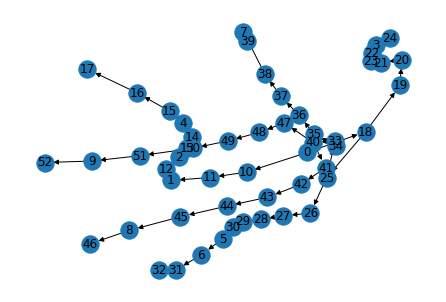

In [15]:
NTD = s.nice_tree_decompose(TD)
plot_graph(NTD, label=False, directed=True)

In [16]:
print_tree(NTD, NTD.root)

[0]frozenset({34, 9, 22, 24, 31})
--[10]frozenset({34, 9, 22, 24, 31})
----[11]frozenset({24, 9, 22, 31})
------[1]frozenset({9, 19, 22, 24, 31})
--------[12]frozenset({24, 9, 19, 22})
----------[2]frozenset({9, 12, 19, 22, 24})
------------[13]frozenset({9, 19, 12, 22})
--------------[14]frozenset({19, 12, 22})
----------------[4]frozenset({16, 19, 12, 22})
------------------[15]frozenset({19, 12, 22})
--------------------[16]frozenset({12, 22})
----------------------[17]frozenset({22})
--[18]frozenset({34, 9, 22, 24, 31})
----[19]frozenset({34, 9, 22, 24, 31})
------[20]frozenset({24, 34, 22, 31})
--------[21]frozenset({24, 34, 31})
----------[3]frozenset({24, 34, 28, 31})
------------[22]frozenset({34, 28, 31})
--------------[23]frozenset({28, 31})
----------------[24]frozenset({31})
----[25]frozenset({34, 9, 22, 24, 31})
------[26]frozenset({34, 9, 22, 24, 31})
--------[27]frozenset({9, 34, 22, 31})
----------[28]frozenset({9, 22, 31})
------------[29]frozenset({9, 31})
-----------

In [17]:
# dynamic programming
leaves = NTD.out_degrees.index.values[NTD.out_degrees['degree'] == 0]

In [19]:
from profiler.utility import find_all_subsets

In [ ]:
def union_and_check_cycle(sets):
    # TODO
    s0 = sets[0]
    for s in sets[1:]:
        for (u,v) in s:
            # transitive closure
            pass

In [1]:
def score(j, S):
    xs = inv_cov.loc[S, :]
    xj = inv_cov.loc[j, :]
    bj = np.linalg.inv(xs.transpose()*xs)*xs.transpose()*xj
    score = np.sum(np.square(xj-xs*bj))/float(inv_cov.shape[0])/s.param['sigma']
    return score

def is_eq_dict(dic1, dic2):
    # TODO
    if len(dic1.keys()) != len(dic2.keys()):
        return False
    for k1 in dic1:
        if k1 not in dic2:
            return False
        if dic1[k1] != dic2[k2]:
            return False
    return True
    
def dfs(G, tree, t):
    # R(a,p,s): a - parent sets; p: directed path, s:score
    if tree.node_types[t] == JOIN:
        candidates = {}
        # has children t1 and t2
        t1, t2 = tree.get_children(t)
        for (a1, p1, s1) in dfs(G, tree, t1):
            for (a2, p2, s2) in dfs(G, tree, t2):
                if not is_eq_dict(a1, a2):
                    continue
                a = a1
                p = union_and_check_cycle([p1, p2])
                if p is None:
                    continue
                s = s1 + s2
                if s not in candidates:
                    candidates[s] = []
                candidates[s].append((a, p, s))
        Rt = candidates[min(list(candidates.keys()))]
        return Rt
    elif tree.node_types[t] == INTRO:
        # has only one child
        child = tree.get_children(t)[0]
        Xt = tree.idx_to_name[t]
        Xtc = tree.idx_to_name[child]
        v0 = list(Xt - tree.idx_to_name[child])[0]
        Rt = []
        for P in find_all_subsets(set(G.get_neighbors(v0))):
            for (aa, pp, ss) in dfs(G, tree, child):
                a = {}
                a[v0] = P
                for v in Xtc:
                    a[v] = aa[v]
                p = union_and_check_cycle([pp, [(u, v0) for u in P], [(vv, u) for u in Xtc for vv in aa[u]]])
                if p is None:
                    continue
                s = ss
                # since score does not change, all should have same score
                Rt.append(s)
    elif tree.node_types[t] == FORGET:
        # has only one child
        child = tree.get_children(t)[0]
        Xt = tree.idx_to_name[t]
        v0 = list(tree.idx_to_name[child] - Xt)[0]
        candidates = {}
        for (aa, pp, ss) in dfs(G, tree, child):
            a = {}
            for v in Xt:
                a[v] = aa[v]
            p = [(u,v) for (u,v) in pp if u in Xt and v in Xt]
            if p is None:
                continue
            s = ss + score(v0, aa[v0])
            if s not in candidates:
                candidates[s] = []
            candidates[s].append((a, p, s))
        Rt = candidates[min(list(candidates.keys()))]
    else:
        # leaf
        min_score = 100000
        # 1. P is a subset of all the neighbors of the vertex in leaf 
        candidates = {}
        Xt = tree.idx_to_name[t]
        v = list(Xt)[0]
        for P in find_all_subsets(set(G.get_neighbors(v))):
            a = {v: P}
            s = score(list(Xt)[0], P)
            p = [(p,v) for p in P]
            if s not in candidates:
                candidates[s] = []
            candidates[s].append((a, p, s))
        # get minimal-score records
        Rt = candidates[min(list(candidates.keys()))]
    return Rt

In [22]:
R = dfs(NTD.root)

frozenset({34})